notes to self:

* add all freqs and orders by nesting `Freqs/Order`
* no p-values since it's hard to estimate DFs
* try with averages (?)
* models for 5 and 10 Hz but with all orders
* `simr`, `flexplot` libraries

# Data import

In [1]:
library(tidyverse)
library(broom)
library(lme4)
library(Hmisc)
library(lattice)
library(ggpubr)
library(effectsize)
library(gridExtra)

options(repr.plot.width=7, repr.plot.height=4)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
Warning message:
“package ‘tibble’ was built under R version 3.6.3”Warning message:
“package ‘tidyr’ was built under R version 3.6.3”Warning message:
“package ‘dplyr’ was built under R version 3.6.3”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“package ‘broom’ was built under R version 3.6.3”Warning message:
“package ‘lme4’ was built under R version 3.6.3”Loading required package: Matrix

Attaching package:

In [2]:
residuals_plots <- function(model){
    p1 <- ggplot(data = data.frame(residuals = summary(model)$res)) +
        geom_histogram(aes(x = residuals), bins = 25, 
                       fill = "lightblue", color = "black") +
        labs(title = "Histogram of Residuals")

    p2 <- ggplot(data = data.frame(residuals = summary(model)$res), 
           aes(sample = residuals)) +
        stat_qq() + 
        stat_qq_line() +
        labs(title = "QQ Plot of Residuals")
    
    grid.arrange(p1, p2, nrow = 1)
    
    p1 <- plot(model, resid(.) ~ fitted(.), abline=0, main = "All Data")
    p2 <- plot(model, resid(.) ~ fitted(.)|Animal, abline=0, main = "By Animal")
    
    grid.arrange(p1, p2, nrow = 1, widths = c(1.5,2))
}

In [3]:
AVRECPeakAM <- read_csv(file = "../Data/AVRECPeakAMST.csv")

Parsed with column specification:
cols(
  Group = col_character(),
  Animal = col_character(),
  Layer = col_character(),
  Measurement = col_character(),
  ClickFreq = col_double(),
  OrderofClick = col_double(),
  TrialNumber = col_double(),
  PeakAmp = col_double(),
  PeakLat = col_double(),
  RMS = col_double()
)


# Modeling

![](LMM_design.png)

Notes:

* `RMS` variable was log-transformed since the distribution was right-skewed (resulting in a fan shape residuals plots).
* Values in `coef()` function is the actual intercept for an animal. `ranef()` shows the difference from a "main" intercept.


Warning message:
“Removed 107928 rows containing non-finite values (stat_bin).”Warning message:
“Removed 107928 rows containing non-finite values (stat_bin).”

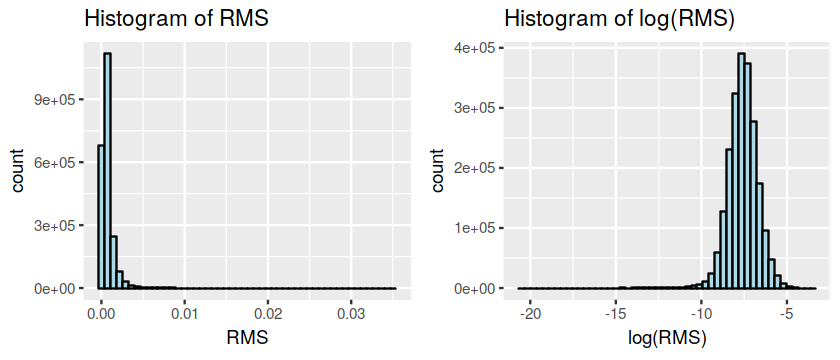

In [4]:
p1 <- ggplot(data = AVRECPeakAM) +
    geom_histogram(aes(x = RMS), bins = 50, 
                   fill = "lightblue", color = "black") +
    labs(title = "Histogram of RMS")

p2 <- ggplot(data = AVRECPeakAM) +
    geom_histogram(aes(x = log(RMS)), bins = 50, 
                   fill = "lightblue", color = "black") +
    labs(title = "Histogram of log(RMS)")

options(repr.plot.width=7, repr.plot.height=3)
grid.arrange(p1, p2, nrow = 1)

## logRMS ~ Group\*Measurement\*Layer + ClickFreq + (...|Animal)

* Random effect: Animal
* Fixed effect: Group\*Measurement\*Layer, ClickFreq
* Measurement = ["preAM_1", "AM_1"], [0, 1]
* OrderofClick = 1

In [5]:
temp_df <- AVRECPeakAM %>% 
    filter(
        OrderofClick == 1,
        Layer != "All",
#         RMS < 0.01, # remove outliers?
        Measurement %in% c("preAM_1", "AM_1")) %>%  
    mutate(logRMS = log(RMS),
           MeasurementPost = ifelse(Measurement == "AM_1", 1, 0)) %>% 
    ungroup() %>% 
    drop_na()

temp_df$Measurement <- factor(
    x = temp_df$Measurement, 
    levels = c("preAM_1", "AM_1"))

temp_df$Layer <- factor(x = temp_df$Layer)
# temp_df$ClickFreq <- factor(x = temp_df$ClickFreq)

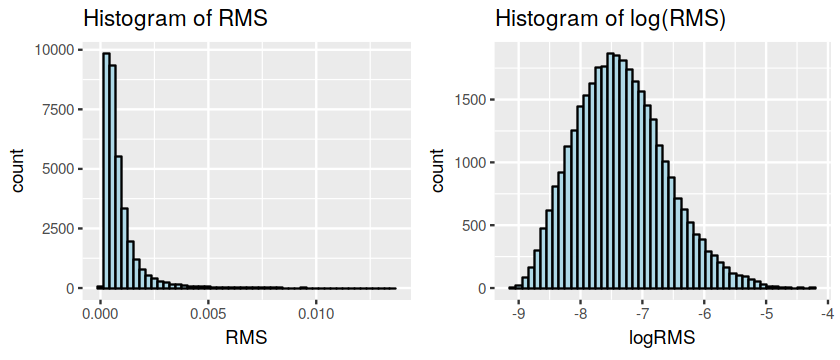

In [6]:
p1 <- ggplot(data = temp_df) +
    geom_histogram(aes(x = RMS), bins = 50, 
                   fill = "lightblue", color = "black") +
    labs(title = "Histogram of RMS")

p2 <- ggplot(data = temp_df) +
    geom_histogram(aes(x = logRMS), bins = 50, 
                   fill = "lightblue", color = "black") +
    labs(title = "Histogram of log(RMS)")

options(repr.plot.width=7, repr.plot.height=3)
grid.arrange(p1, p2, nrow = 1)

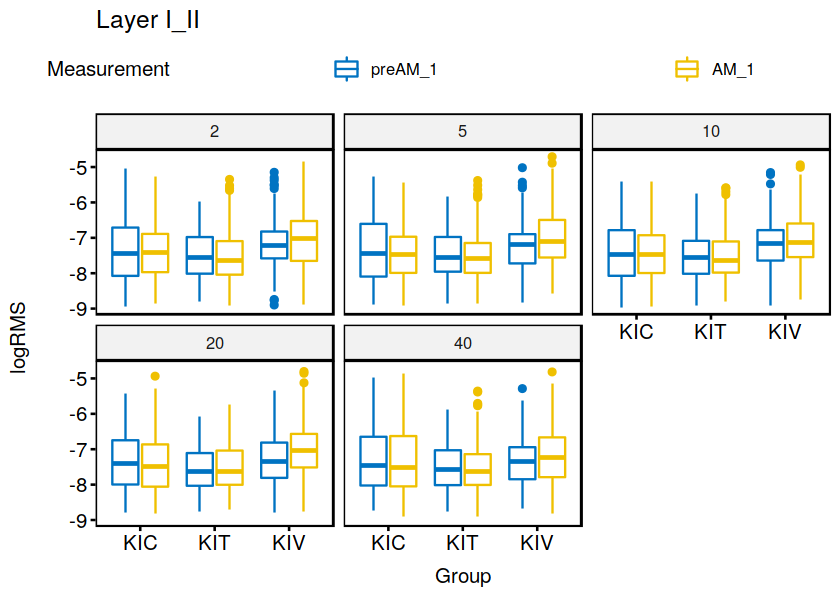

In [7]:
options(repr.plot.width=7, repr.plot.height=5)

temp_df  %>% 
    filter(Layer == "I_II") %>%  # "I_II", "IV", "V", "VI"
ggboxplot(
    x = "Group", y = "logRMS", color = "Measurement", 
    palette = "jco", facet.by = "ClickFreq", main = "Layer I_II" #, add = "jitter",
)

In [8]:
head(temp_df)

Group,Animal,Layer,Measurement,ClickFreq,OrderofClick,TrialNumber,PeakAmp,PeakLat,RMS,logRMS,MeasurementPost
KIC,KIC02,I_II,preAM_1,2,1,1,0.001483936,21,0.0007726788,-7.165647,0
KIC,KIC02,I_II,preAM_1,2,1,2,0.001250764,28,0.0005488973,-7.507599,0
KIC,KIC02,I_II,preAM_1,2,1,3,0.004439501,34,0.0018238557,-6.306803,0
KIC,KIC02,I_II,preAM_1,2,1,4,0.002350430,46,0.0016744506,-6.392270,0
KIC,KIC02,I_II,preAM_1,2,1,5,0.001809858,76,0.0009579004,-6.950767,0
KIC,KIC02,I_II,preAM_1,2,1,6,0.002856180,81,0.0017449100,-6.351052,0


### (1|Animal/TrialNumber); random intercept, fixed slope

We assume that every animal has different "starting point", but the same rate of change (slope).

In [9]:
model0 <- lmer(
    formula = logRMS ~ Group*MeasurementPost*Layer + ClickFreq + 
#         (1|ClickFreq) + 
        (1|Animal/TrialNumber), 
    data = temp_df,
    REML = TRUE)
summary(model0)

# ClickFreq/OrderofClick
# control = lmerControl(optimizer ='optimx', optCtrl=list(method='nlminb'))


Correlation matrix not shown by default, as p = 25 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML ['lmerMod']
Formula: 
logRMS ~ Group * MeasurementPost * Layer + ClickFreq + (1 | Animal/TrialNumber)
   Data: temp_df

REML criterion at convergence: 65562.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4598 -0.6835 -0.0050  0.6678  4.6780 

Random effects:
 Groups             Name        Variance Std.Dev.
 TrialNumber:Animal (Intercept) 0.006275 0.07922 
 Animal             (Intercept) 0.098472 0.31380 
 Residual                       0.388117 0.62299 
Number of obs: 34280, groups:  TrialNumber:Animal, 1302; Animal, 27

Fixed effects:
                                   Estimate Std. Error t value
(Intercept)                      -7.2813961  0.1010740 -72.040
GroupKIT                         -0.1178256  0.1429627  -0.824
GroupKIV                          0.0663623  0.1572074   0.422
MeasurementPost                  -0.0622335  0.0236441  -2.632
LayerIV                           0.3213435  0.0259561  12.380
LayerV                       

$`TrialNumber:Animal`

$Animal


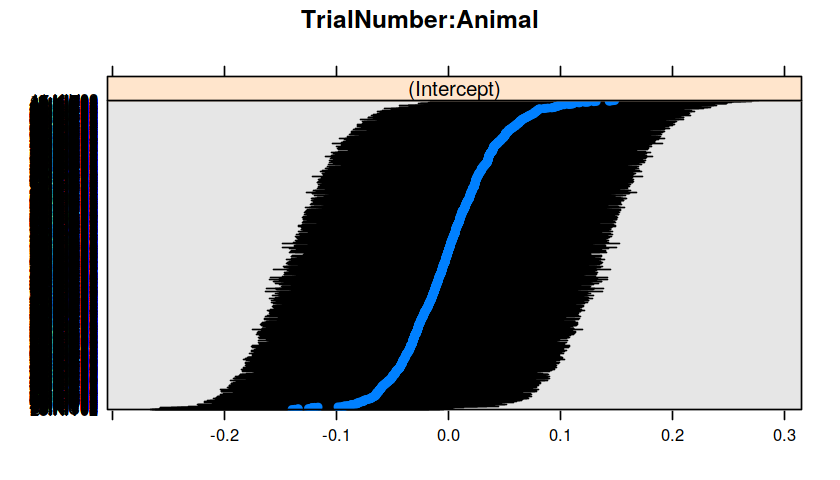

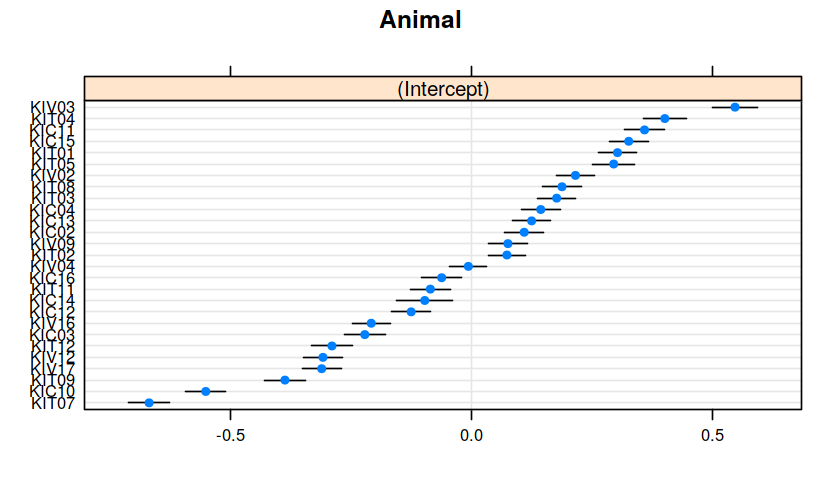

In [51]:
options(repr.plot.width=7, repr.plot.height=4)
dotplot(ranef(model0, condVar = TRUE))

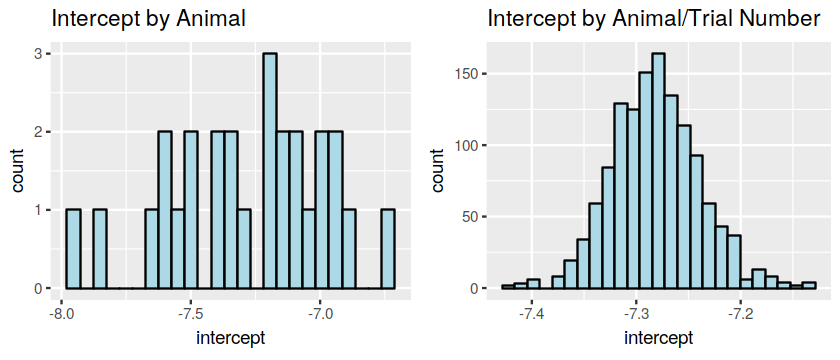

In [52]:
p1 <- ggplot(data = data.frame(intercept = coef(model0)$Animal$`(Intercept)`)) +
    geom_histogram(aes(x = intercept), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Intercept by Animal")

p2 <- ggplot(data = data.frame(intercept = coef(model0)$`TrialNumber:Animal`$`(Intercept)`)) +
    geom_histogram(aes(x = intercept), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Intercept by Animal/Trial Number")

options(repr.plot.width=7, repr.plot.height=3)
grid.arrange(p1, p2, nrow = 1)

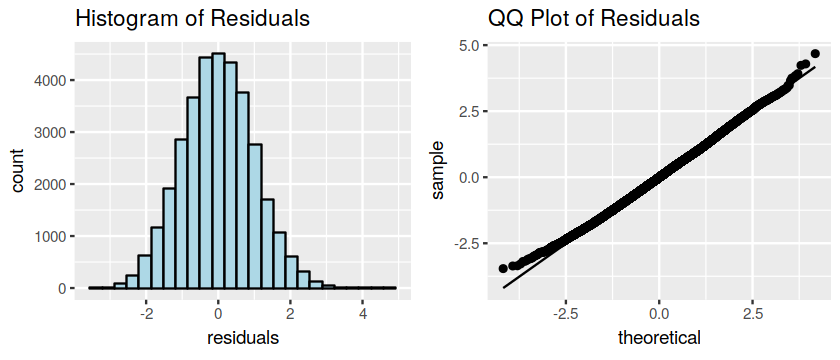

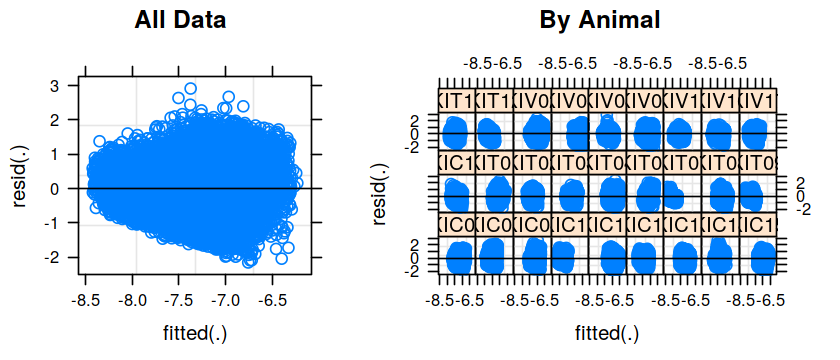

In [53]:
options(repr.plot.width=7, repr.plot.height=3)
residuals_plots(model = model0)

### (Measurement|Animal/TrialNumber); random intercept & slopes

$$logRMS = b^*_0 + b_1 Group + b^*_2 MeasurementPost + b_3 Layer + b_4 Group*MeasurementPost*Layer + b_5 ClickFreq$$ 

$$b^*_0 = b_0 + b^A_0 + b^{A:T}_0$$

$$b^*_2 = b_2 + b^A_2 + b^{A:T}_2$$

In [10]:
model1 <- lmer(
    formula = logRMS ~ Group*MeasurementPost*Layer + ClickFreq + 
#         (1|ClickFreq) + 
        (MeasurementPost|Animal/TrialNumber), 
    data = temp_df,
    REML = TRUE)
summary(model1)


Correlation matrix not shown by default, as p = 25 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML ['lmerMod']
Formula: 
logRMS ~ Group * MeasurementPost * Layer + ClickFreq + (MeasurementPost |  
    Animal/TrialNumber)
   Data: temp_df

REML criterion at convergence: 64993.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5981 -0.6786 -0.0053  0.6713  4.6998 

Random effects:
 Groups             Name            Variance Std.Dev. Corr 
 TrialNumber:Animal (Intercept)     0.004413 0.06643       
                    MeasurementPost 0.013231 0.11502  -0.45
 Animal             (Intercept)     0.102224 0.31972       
                    MeasurementPost 0.034213 0.18497  -0.22
 Residual                           0.378925 0.61557       
Number of obs: 34280, groups:  TrialNumber:Animal, 1302; Animal, 27

Fixed effects:
                                   Estimate Std. Error t value
(Intercept)                      -7.2807632  0.1028521 -70.789
GroupKIT                         -0.1163225  0.1454997  -0.799
GroupKIV                          0.06

* Intercept: Group `KIC`, Layer `I_II`, pre Measurement, -0.0040315 * `ClickFreq`
* with increase of `ClickFreq` by 1, `RMS` changes by ~0.996

For Layer `I_II` (constant `ClickFreq`):

* Group `KIT`: RMS changes by ~0.989 after signal;
* Group `KIV`: RMS changes by ~1.283 after signal;
* Group `KIC`: RMS changes by ~0.959 after signal;

For Layer `IV` (constant `ClickFreq`):

* Group `KIT`: RMS changes by ~0.852 after signal;
* Group `KIV`: RMS changes by ~1.224 after signal;
* Group `KIC`: RMS changes by ~1.011 after signal;

In [256]:
predict(
    object = model1, 
    re.form = NA, # set random effects to zero
    newdata = data.frame(
        Group = "KIC", 
        MeasurementPost = 1,
        Layer = "IV",
        ClickFreq = 1))

1 
-6.954707

$`TrialNumber:Animal`

$Animal


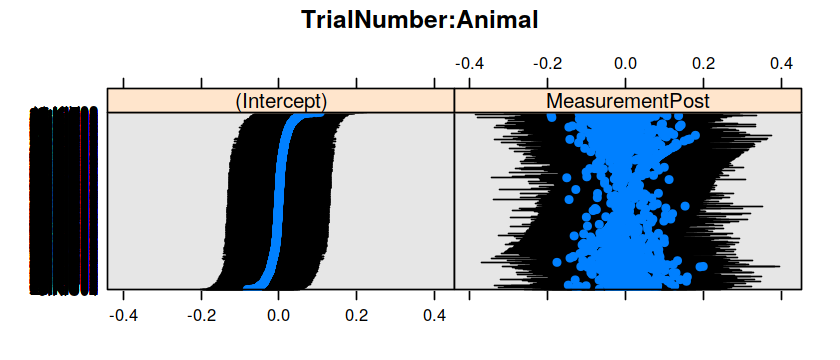

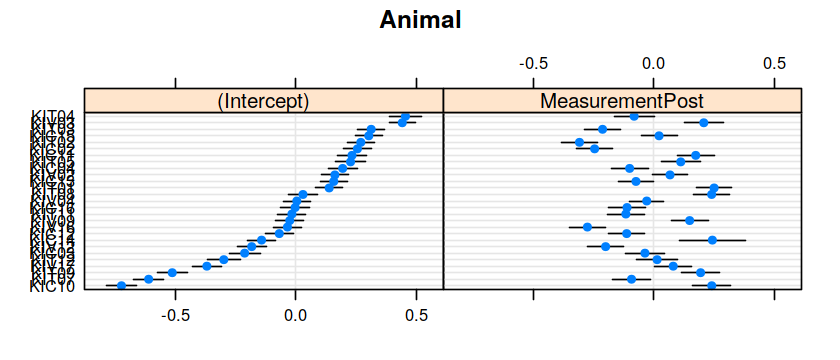

In [55]:
options(repr.plot.width=7, repr.plot.height=3)
dotplot(ranef(model1, condVar = TRUE))

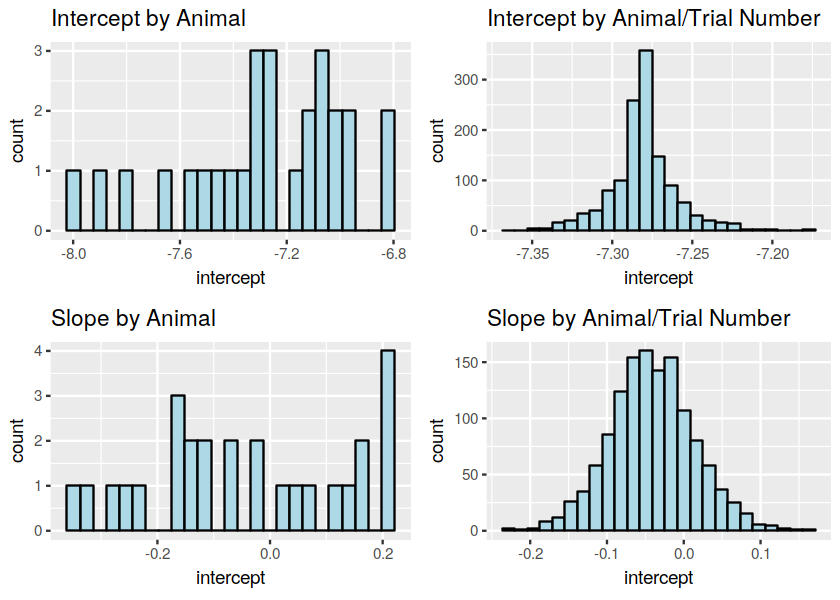

In [56]:
p1 <- ggplot(data = data.frame(intercept = coef(model1)$Animal$`(Intercept)`)) +
    geom_histogram(aes(x = intercept), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Intercept by Animal")

p2 <- ggplot(data = data.frame(intercept = coef(model1)$`TrialNumber:Animal`$`(Intercept)`)) +
    geom_histogram(aes(x = intercept), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Intercept by Animal/Trial Number")

p3 <- ggplot(data = data.frame(intercept = coef(model1)$Animal$MeasurementPost)) +
    geom_histogram(aes(x = intercept), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Slope by Animal")

p4 <- ggplot(data = data.frame(intercept = coef(model1)$`TrialNumber:Animal`$MeasurementPost)) +
    geom_histogram(aes(x = intercept), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Slope by Animal/Trial Number")

options(repr.plot.width=7, repr.plot.height=5)
grid.arrange(p1, p2, p3, p4, nrow = 2)

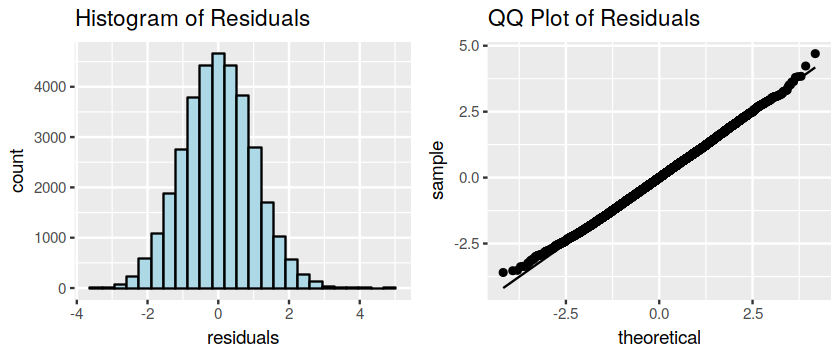

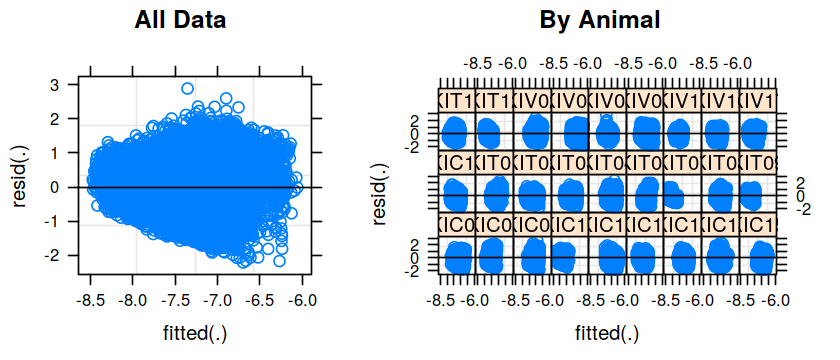

In [57]:
options(repr.plot.width=7, repr.plot.height=3)
residuals_plots(model = model1)

### (-1 + Measurement|Animal); fixed intercept, random slopes

In [11]:
model2 <- lmer(
    formula = logRMS ~ Group*MeasurementPost*Layer + ClickFreq + 
#         (1|ClickFreq) + 
        (0 + MeasurementPost|Animal/TrialNumber), 
    data = temp_df,
    REML = TRUE)
summary(model2)


Correlation matrix not shown by default, as p = 25 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML ['lmerMod']
Formula: 
logRMS ~ Group * MeasurementPost * Layer + ClickFreq + (0 + MeasurementPost |  
    Animal/TrialNumber)
   Data: temp_df

REML criterion at convergence: 67773.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4564 -0.6787 -0.0126  0.6690  4.5146 

Random effects:
 Groups             Name            Variance Std.Dev.
 TrialNumber:Animal MeasurementPost 0.008636 0.09293 
 Animal             MeasurementPost 0.110646 0.33264 
 Residual                           0.415053 0.64425 
Number of obs: 34280, groups:  TrialNumber:Animal, 1302; Animal, 27

Fixed effects:
                                   Estimate Std. Error  t value
(Intercept)                      -7.2938482  0.0192929 -378.058
GroupKIT                         -0.1657977  0.0273184   -6.069
GroupKIV                          0.0919498  0.0283265    3.246
MeasurementPost                  -0.0325204  0.1081799   -0.301
LayerIV                           0.3462562  0.

$`TrialNumber:Animal`

$Animal


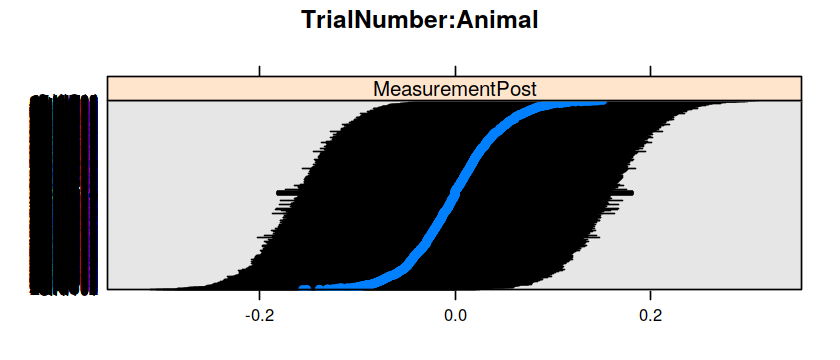

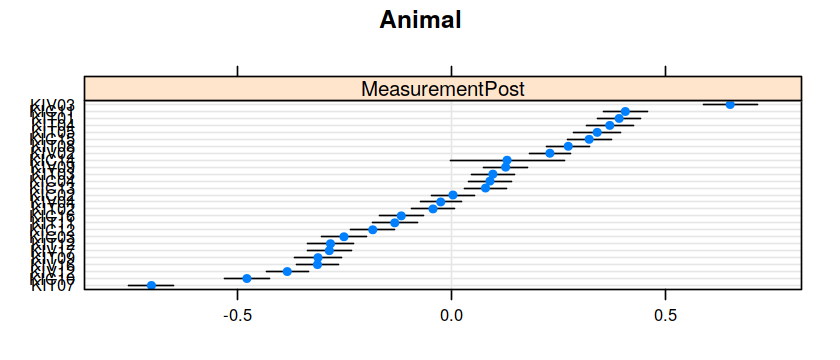

In [60]:
options(repr.plot.width=7, repr.plot.height=3)
dotplot(ranef(model2, condVar = TRUE))

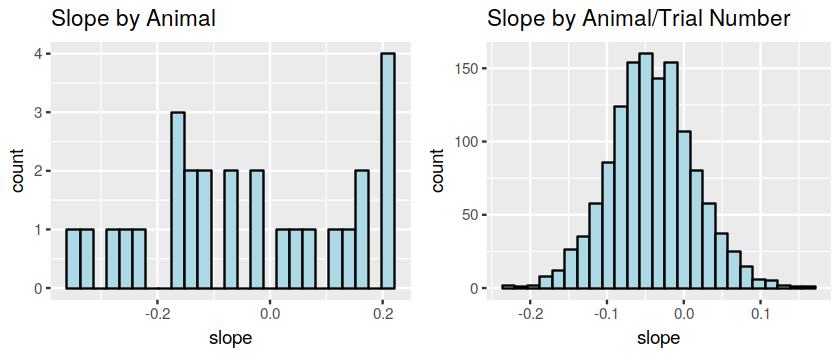

In [66]:
p1 <- ggplot(data = data.frame(slope = coef(model1)$Animal$MeasurementPost)) +
    geom_histogram(aes(x = slope), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Slope by Animal")

p2 <- ggplot(data = data.frame(slope = coef(model1)$`TrialNumber:Animal`$MeasurementPost)) +
    geom_histogram(aes(x = slope), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Slope by Animal/Trial Number")

options(repr.plot.width=7, repr.plot.height=3)
grid.arrange(p1, p2, nrow = 1)

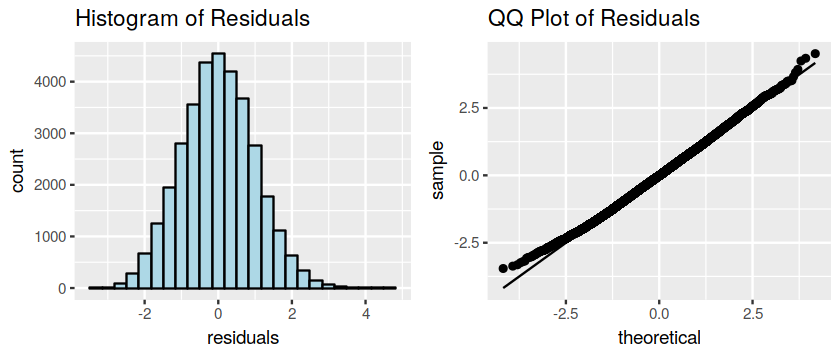

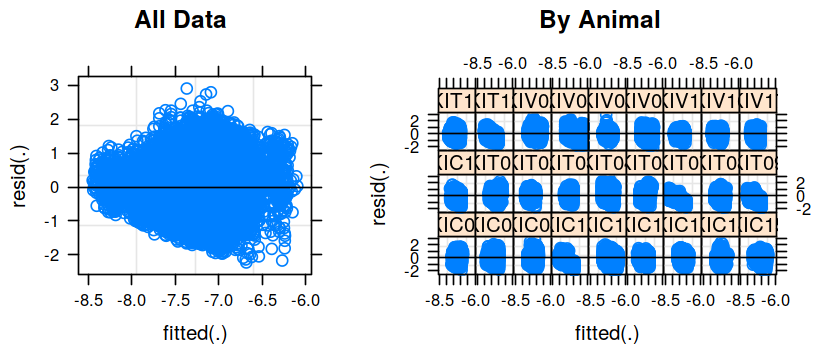

In [61]:
options(repr.plot.width=7, repr.plot.height=3)
residuals_plots(model = model2)

### (Measurement|Animal); fixed intercept, random slopes; without Group

In [17]:
model3 <- lmer(
    formula = logRMS ~ MeasurementPost*Layer + ClickFreq + 
        (MeasurementPost|Animal/TrialNumber), 
    data = temp_df,
    REML = TRUE,
    control = lmerControl(optimizer ='optimx', optCtrl=list(method='nlminb')))
summary(model3)

Loading required namespace: optimx


Linear mixed model fit by REML ['lmerMod']
Formula: logRMS ~ MeasurementPost * Layer + ClickFreq + (MeasurementPost |  
    Animal/TrialNumber)
   Data: temp_df
Control: lmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

REML criterion at convergence: 65125.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5600 -0.6772 -0.0013  0.6710  4.6113 

Random effects:
 Groups             Name            Variance Std.Dev. Corr 
 TrialNumber:Animal (Intercept)     0.004296 0.06554       
                    MeasurementPost 0.013263 0.11516  -0.44
 Animal             (Intercept)     0.096748 0.31104       
                    MeasurementPost 0.042015 0.20498  -0.17
 Residual                           0.381045 0.61729       
Number of obs: 34280, groups:  TrialNumber:Animal, 1302; Animal, 27

Fixed effects:
                          Estimate Std. Error  t value
(Intercept)             -7.3001949  0.0610380 -119.601
MeasurementPost          0.0446130  0.0420615   

$`TrialNumber:Animal`

$Animal


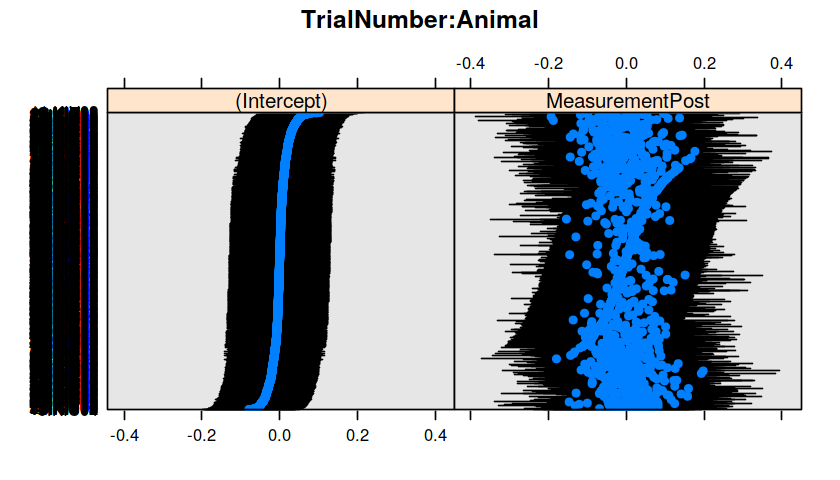

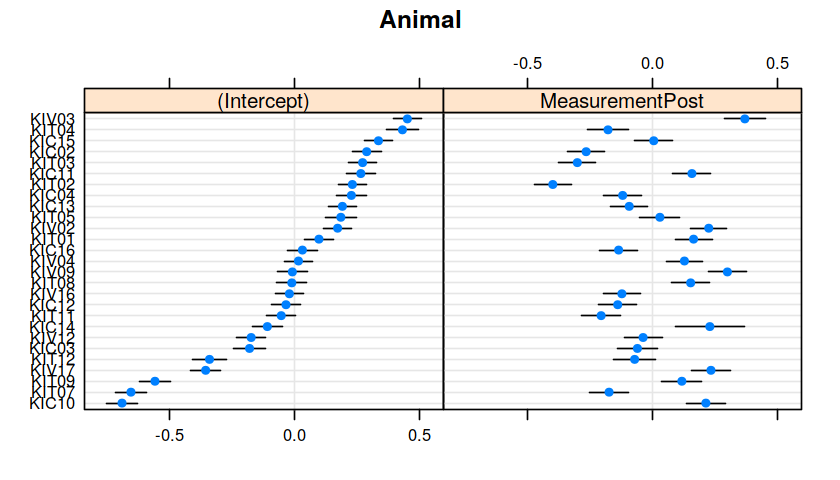

In [24]:
options(repr.plot.width=7, repr.plot.height=4)
dotplot(ranef(model3, condVar = TRUE))

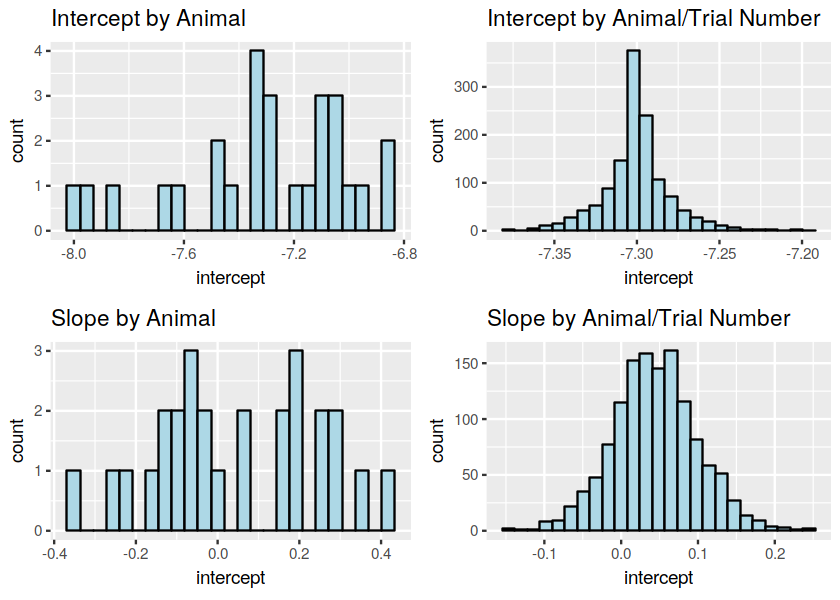

In [25]:
p1 <- ggplot(data = data.frame(intercept = coef(model3)$Animal$`(Intercept)`)) +
    geom_histogram(aes(x = intercept), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Intercept by Animal")

p2 <- ggplot(data = data.frame(intercept = coef(model3)$`TrialNumber:Animal`$`(Intercept)`)) +
    geom_histogram(aes(x = intercept), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Intercept by Animal/Trial Number")

p3 <- ggplot(data = data.frame(intercept = coef(model3)$Animal$MeasurementPost)) +
    geom_histogram(aes(x = intercept), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Slope by Animal")

p4 <- ggplot(data = data.frame(intercept = coef(model3)$`TrialNumber:Animal`$MeasurementPost)) +
    geom_histogram(aes(x = intercept), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Slope by Animal/Trial Number")

options(repr.plot.width=7, repr.plot.height=5)
grid.arrange(p1, p2, p3, p4, nrow = 2)

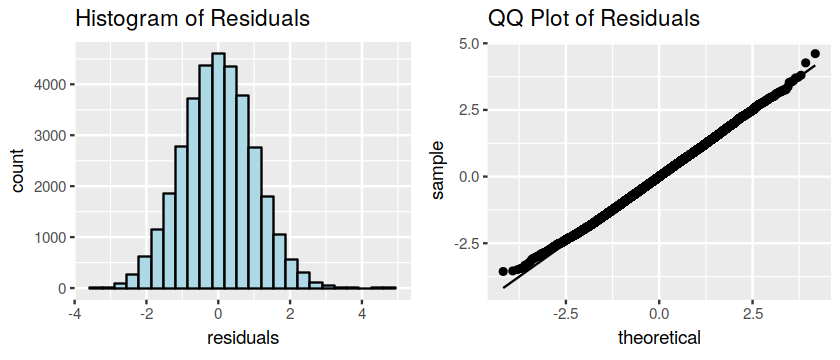

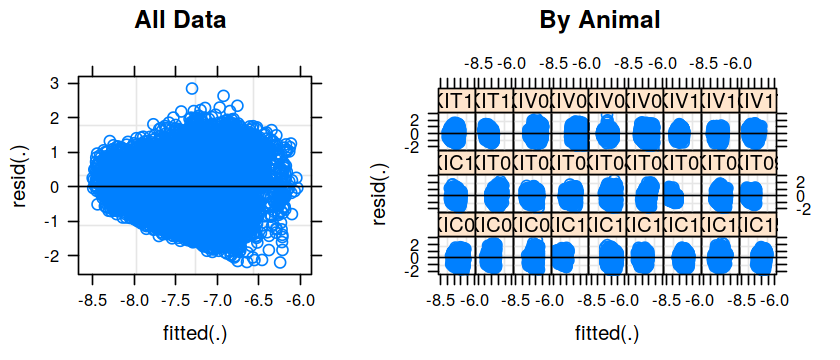

In [26]:
options(repr.plot.width=7, repr.plot.height=3)
residuals_plots(model = model3)

### Comparison

Akaike information criterion (AIC) - the smaller, the better

$$AIC=2k-2 \mathrm {\ln}(\hat {L})$$

* k = number of estimated parameters in the model
* $\hat{L}$ = maximum value of the likelihood function for the model

In [18]:
AIC(model0)

[1] 65618.43

In [19]:
AIC(model1)

[1] 65057.57

In [20]:
AIC(model2)

[1] 67829.67

In [21]:
AIC(model3)

[1] 65157.62

In [27]:
anova(model1, model3)

refitting model(s) with ML (instead of REML)


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
model3,16,65092.62,65227.70,-32530.31,65060.62,NA,NA,NA
model1,32,64917.53,65187.68,-32426.77,64853.53,207.0882,16,2.916675e-35


How to report your results in paper (from https://www.youtube.com/watch?v=VmPouLbvfXI&t=1999s):

"A linear mixed model was fit with varying intercepts by Animal and Trial and varying correlated slopes by Measurement. The dependent variable was log-transformed. The results show the effect of group was significant $\chi^2 = 207.1$, $p<<0.01$.

## logRMS ~ Group*Measurement*Layer + ClickFreq/OrderofClick + (...|Animal)

In [73]:
temp_df <- AVRECPeakAM %>% 
    filter(
        Layer != "All",
#         RMS < 0.01, # remove outliers?
        Measurement %in% c("preAM_1", "AM_1")) %>%  
    mutate(logRMS = log(RMS),
           MeasurementPost = ifelse(Measurement == "AM_1", 1, 0)) %>% 
    ungroup() %>% 
    drop_na()

temp_df$Measurement <- factor(
    x = temp_df$Measurement, 
    levels = c("preAM_1", "AM_1"))

temp_df$Layer <- factor(x = temp_df$Layer)
# temp_df$ClickFreq <- factor(x = temp_df$ClickFreq)

### (Measurement|Animal/TrialNumber);

In [74]:
model3 <- lmer(
    formula = logRMS ~ Group*MeasurementPost*Layer + ClickFreq/OrderofClick + 
#         (1|ClickFreq) + 
        (MeasurementPost|Animal/TrialNumber), 
    data = temp_df,
    REML = TRUE)
summary(model3)


Correlation matrix not shown by default, as p = 26 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML ['lmerMod']
Formula: logRMS ~ Group * MeasurementPost * Layer + ClickFreq/OrderofClick +  
    (MeasurementPost | Animal/TrialNumber)
   Data: temp_df

REML criterion at convergence: 915705.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4891 -0.7008 -0.0464  0.6559  5.9469 

Random effects:
 Groups             Name            Variance Std.Dev. Corr 
 TrialNumber:Animal (Intercept)     0.006842 0.08271       
                    MeasurementPost 0.014921 0.12215  -0.68
 Animal             (Intercept)     0.086667 0.29439       
                    MeasurementPost 0.025881 0.16088  -0.20
 Residual                           0.413432 0.64299       
Number of obs: 466522, groups:  TrialNumber:Animal, 1302; Animal, 27

Fixed effects:
                                   Estimate Std. Error t value
(Intercept)                      -7.295e+00  9.337e-02 -78.129
GroupKIT                         -1.483e-01  1.320e-01  -1.123
GroupKIV                

$`TrialNumber:Animal`

$Animal


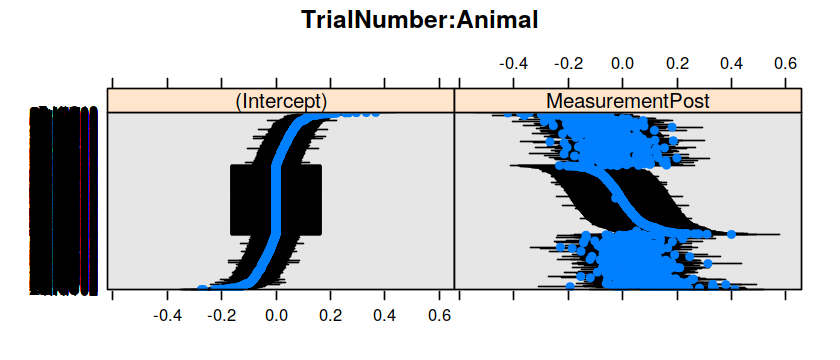

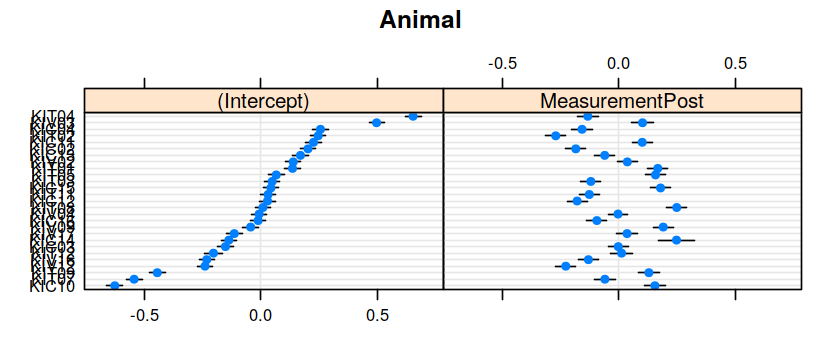

In [75]:
options(repr.plot.width=7, repr.plot.height=3)
dotplot(ranef(model3, condVar = TRUE))

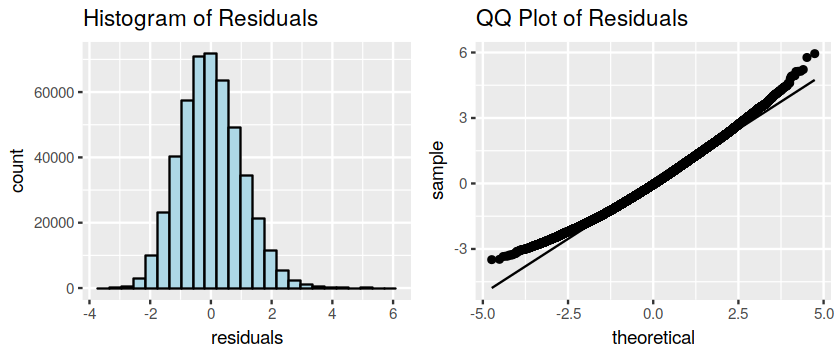

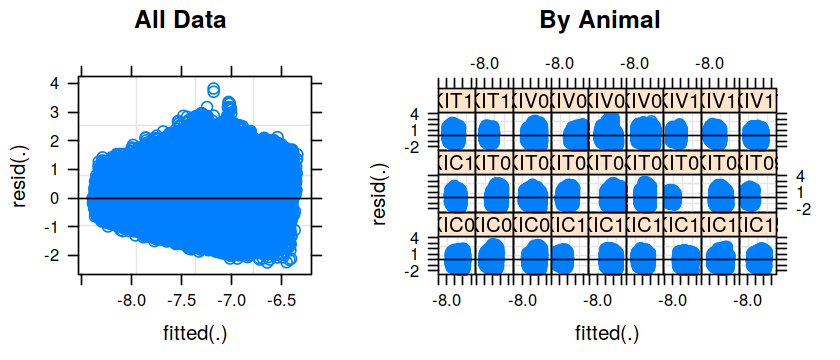

In [76]:
options(repr.plot.width=7, repr.plot.height=3)
residuals_plots(model = model3)